In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact_manual
from sklearn.linear_model import LinearRegression

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Instrumental Variables

## Functions

In [177]:
iv_columns = ['instrument', 'treatment', 'confounder', 'outcome']

def generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T, seed=42):
    """
    Generates IV data from a multivariate Gaussian.
    
    n_samples (int): the number samples to generate
    treat_effect (float): the true effect (coefficient) of the treatment on outcome
    confound_effect (float): the effect of the confounder (coefficient) on the outcome
    I_T (float): instrument strength, the covariance between the instrument and treatment
    C_T (float): confound strength, the covariance between the confound and treatment
    """
    
    idx_dict = {
        'I': 0,
        'T': 1,
        'C': 2,
        'O': 3
    }

    # vars:             I    T    C
    covar = np.array([[1.0, I_T, 0.0], # I
                      [I_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    covar += np.eye(3,3)
    # vars:  I  T  C
    means = [0, 0, 0]

    # generate some data
    np.random.seed(seed)
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)

    O = (confound_effect*data[:, idx_dict['C']]) + (treat_effect*(data[:, idx_dict['T']])) + np.random.normal(0,1,size=n_samples)

    data = np.concatenate([data,O.reshape(-1, 1)], axis=1)

    data_df = pd.DataFrame(data, columns=columns)
    
    return data_df

## Sandbox

In [178]:
treat_effect = 2
confound_effect = 0
n_samples = 1000
I_T = 0.9 # instrument strength
C_T = 0.1 # confound strength
data_df = generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T)

In [179]:
I_T = 1 # instrument strength
C_T = 1 # confound strength
covar = np.array([[1.0, I_T, 0.0], # I
                  [I_T, 1.0, C_T], # T
                  [0.0, C_T, 1.0]])# C

np.linalg.cholesky(covar + (np.eye(3,3)))

array([[1.41421356, 0.        , 0.        ],
       [0.70710678, 1.22474487, 0.        ],
       [0.        , 0.81649658, 1.15470054]])

In [180]:
data_df.corr()

,instrument,treatment,confounder,outcome
instrument,1.000000,0.440669,-0.061992,0.398518
treatment,0.440669,1.000000,0.026336,0.935986
confounder,-0.061992,0.026336,1.000000,0.033185
outcome,0.398518,0.935986,0.033185,1.000000


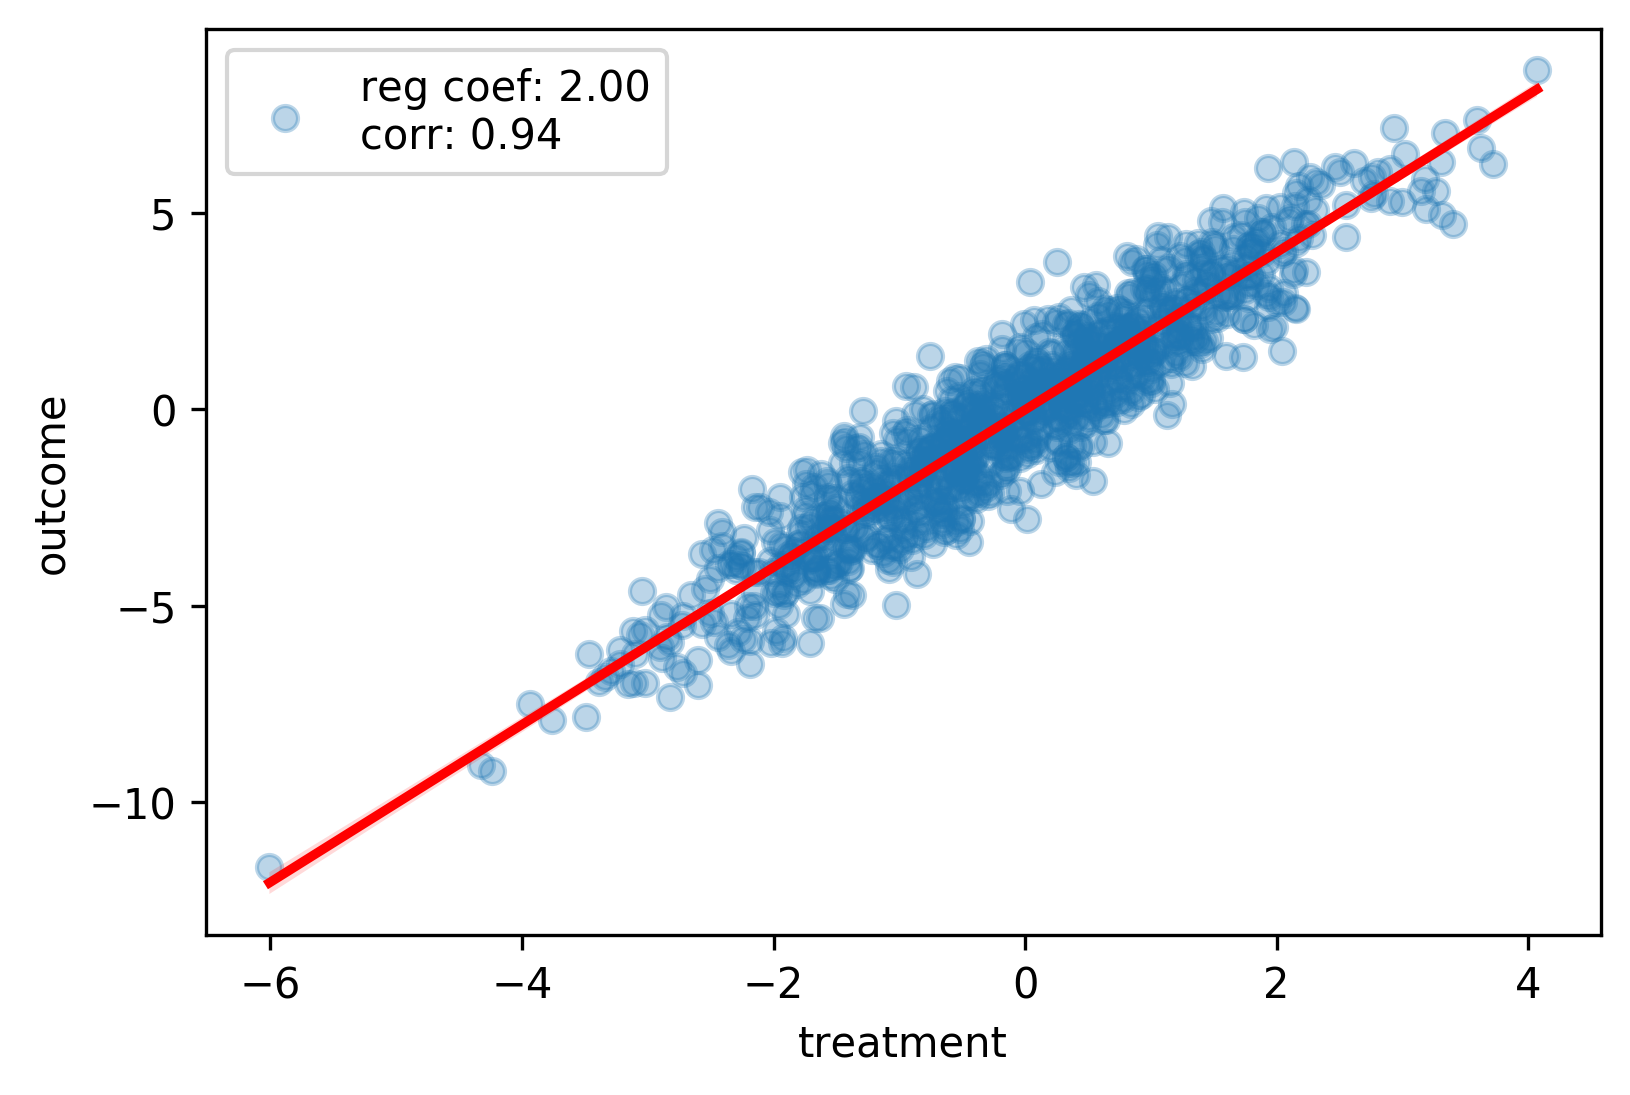

In [181]:
def plot_iv_scatter(x, y, data_df, ax):
    
    scatter_kws = {
        'alpha': 0.3
    }

    line_kws = {
        'color': 'red'
    }
    reg = LinearRegression(fit_intercept=True)
    reg.fit(data_df[[x]], data_df[y])
    
    corr= np.corrcoef(data_df[x], data_df[y])[0,1]
    sns.regplot(x=x, y=y, data=data_df, 
                scatter_kws=scatter_kws,
                line_kws=line_kws,
                label="reg coef: {:.2f}\ncorr: {:.2f}".format(reg.coef_[0], corr),
                ax=ax)
    ax.legend()
ax = plt.gca()
plot_iv_scatter('treatment', 'outcome', data_df, ax)

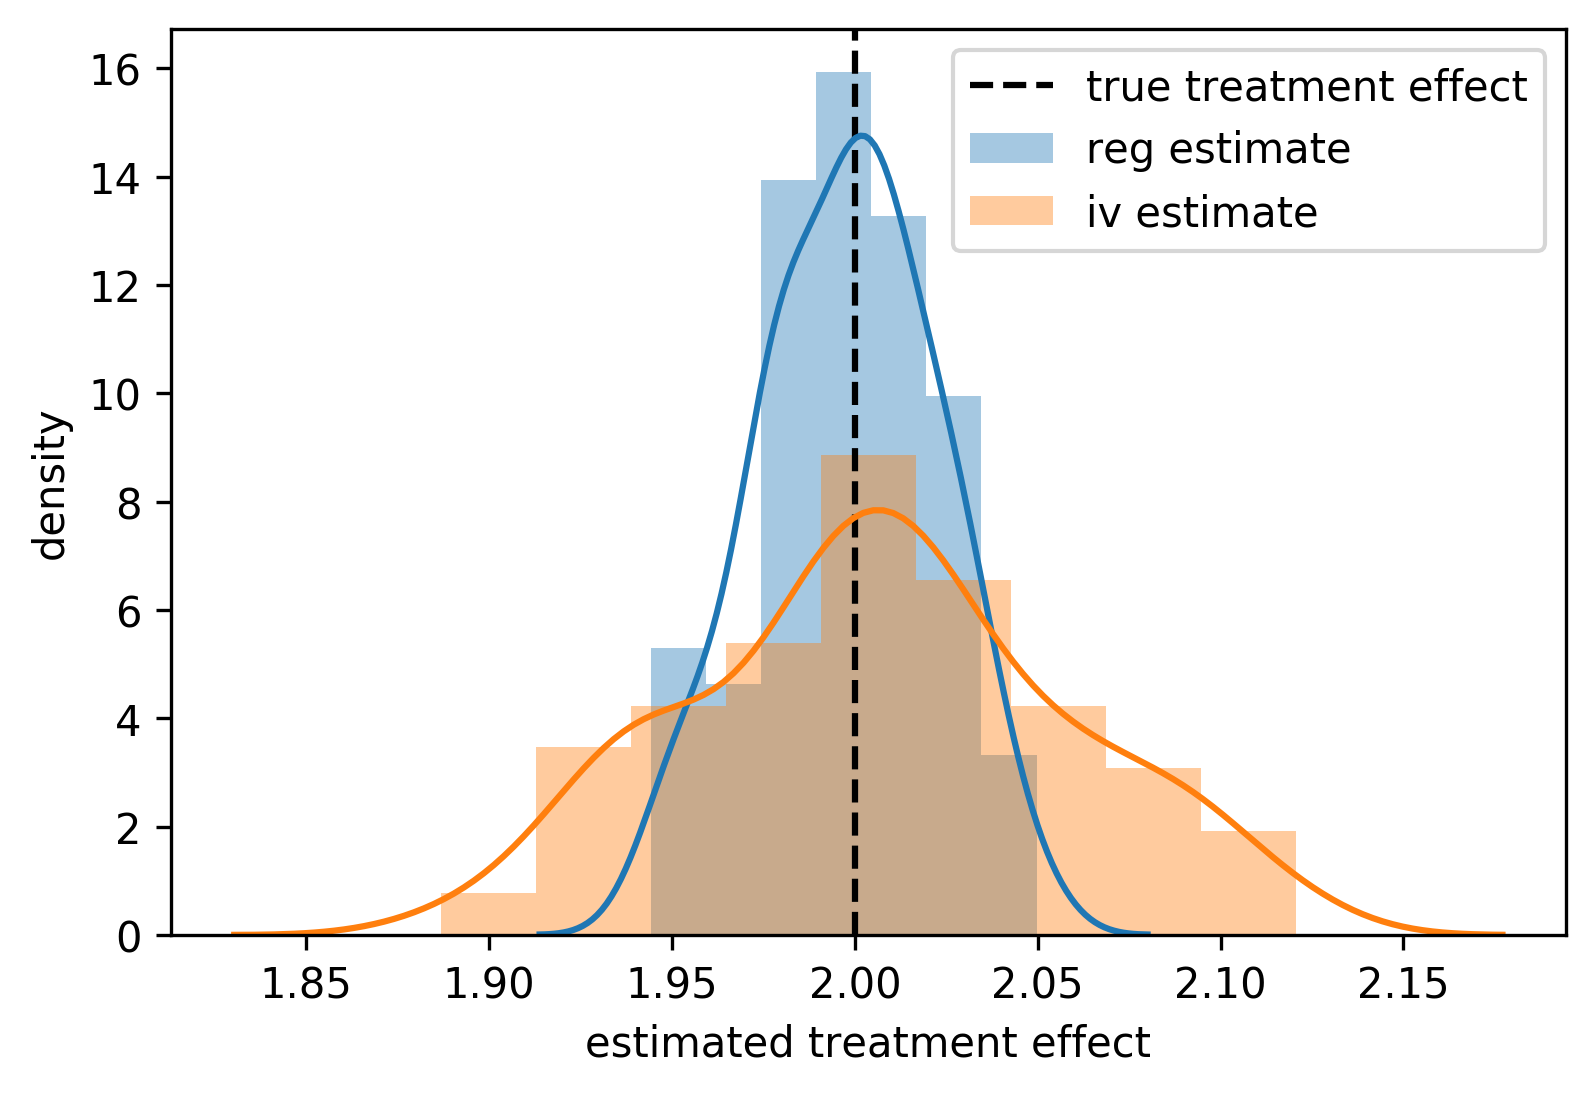

In [182]:
n_trials = 100

def plot_reg_iv_dist(n_trials, n_samples, treat_effect, confound_effect, I_T, C_T, ax):
    reg_estimates = []
    iv_estimates = []
    for t in range(n_trials):
        df = generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T, seed=t)

        reg = LinearRegression(fit_intercept=True)
        reg.fit(df[['treatment']], df['outcome'])
        reg_estimates.append(reg.coef_)

        stage1 = LinearRegression(fit_intercept=True)
        stage1.fit(df[['instrument']], df['treatment'])
        t_hat = stage1.predict(df[['instrument']])
        stage2 = LinearRegression(fit_intercept=True)
        stage2.fit(t_hat.reshape(-1,1), df['outcome'])
        iv_estimates.append(stage2.coef_)

    ax = plt.gca()
    ax.axvline(x=treat_effect, color='black', ls='--', label="true treatment effect")

    sns.distplot(reg_estimates, ax=ax, label="reg estimate")
    sns.distplot(iv_estimates, ax=ax, label="iv estimate")
    ax.set_ylabel("density")
    ax.set_xlabel("estimated treatment effect")
    ax.legend()

ax = plt.gca()
plot_reg_iv_dist(n_trials, n_samples, treat_effect, confound_effect, I_T, C_T, ax)

## Widget

In [183]:
n_samples = 500
n_trials = 50
x = 'treatment'
y = 'outcome'
from ipywidgets import IntSlider, FloatSlider

style = {'description_width': 'initial'}
n_slider = IntSlider(style=style, description="sample size", min=100, max=1000, step=100)
treat_slider = IntSlider(style=style, description="treatment effect", min=-5, max=5, value=1)
confound_slider = IntSlider(style=style, description="confounder effect",min=-5, max=5, value=-1)
iv_str_slider = FloatSlider(style=style, description="instrument strength", min=-1, max=1, value=0.5)
confound_str_slider = FloatSlider(style=style, description="confounder strength", min=-1, max=1, value=0.5)
@interact_manual(n_samples=n_slider,
                 x=iv_columns, y=iv_columns, 
                 treat_effect=treat_slider, 
                 confound_effect=confound_slider, 
                 instrument_str=iv_str_slider, 
                 confounder_str=confound_str_slider)
def show_iv_widget(n_samples, x, y, treat_effect, confound_effect, instrument_str, confounder_str):
    data_df = generate_iv_data(n_samples, treat_effect, confound_effect, instrument_str, confounder_str)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    
    plot_iv_scatter(x, y, data_df, ax1)
    plot_reg_iv_dist(n_trials, n_samples, treat_effect, confound_effect, instrument_str, confounder_str, ax2)
    fig.suptitle("Instrumental Variable Interactive Widget")
#show_iv_widget(x, y, treat_effect, confound_effect, I_T, C_T)

interactive(children=(IntSlider(value=100, description='sample size', max=1000, min=100, step=100, style=Slide…